**项目：我国研究区域火灾活动的主导时空模式与季节性**

本节目标：
- 明确研究数据与处理流程。
- 构建从原始卫星火点数据到时空统计与可视化的分析管线。
- 产出两类结论：
  1) 全部火灾事件的季节性（按月/季节的时间分布）。
  2) 地理分布（空间聚集、县域尺度分布）。

数据来源与位置：
- 原始数据在 `raw_data/` 下：
  - 卫星火点数据：`raw_data/satellite_fire_data/modis_*.csv`（2010–2019）。
  - 中国县级边界：`raw_data/chn_county/chn_county.shp`。

方法概述：
- 读取并合并 2010–2019 年 MODIS 火点数据；标准化经纬度、时间字段，生成 GeoDataFrame。
- 计算月度与季节聚合，绘制折线图与年×月热力图，刻画季节性。
- 读取县界矢量，做空间连接，统计县域总火点数与年尺度火点数，绘制县域火点分布图。
- 将关键汇总表导出至 `results/` 目录。

注意：
- 代码对常见列名做了鲁棒匹配（latitude/lat、longitude/lon、acq_date/date 等）。
- 若 shapefile 或某些年份数据缺失，流程会给出提示但尽量继续运行。

In [20]:
# 基础库导入与全局设置
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns

# 统一绘图风格
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.unicode_minus'] = False

# 字体设置：自动使用系统中可用的中文字体
from matplotlib import font_manager
def set_chinese_font(preferred=('Microsoft YaHei','SimHei','SimSun','Noto Sans CJK SC','Source Han Sans SC','WenQuanYi Zen Hei')):
    available = set(f.name for f in font_manager.fontManager.ttflist)
    for name in preferred:
        if name in available:
            plt.rcParams['font.sans-serif'] = [name]
            print('使用中文字体:', name)
            return name
    # 兜底：保留默认 sans-serif，并提示
    plt.rcParams['font.sans-serif'] = plt.rcParams.get('font.sans-serif', ['DejaVu Sans'])
    print('未检测到常见中文字体，可能导致中文无法显示。请在系统安装如 SimHei 或 Microsoft YaHei。')
set_chinese_font()

print("Libraries imported and font configured.")

使用中文字体: Microsoft YaHei
Libraries imported and font configured.


In [21]:
# 路径配置与辅助函数
# 自动探测仓库根目录（向上查找包含 raw_data 的目录）
from pathlib import Path

def detect_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'raw_data').exists():
            return p
    # 兜底：若当前在 script/ 下
    return start.parent if start.name == 'script' else start

REPO_ROOT = detect_repo_root()
RAW_DIR = REPO_ROOT / 'raw_data'
FIRE_DIR = RAW_DIR / 'satellite_fire_data'
COUNTY_SHP = RAW_DIR / 'chn_county' / 'chn_county.shp'
RESULTS_DIR = REPO_ROOT / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print('Repo root:', REPO_ROOT)
print('Fire data dir exists:', FIRE_DIR.exists())
print('County shp exists:', COUNTY_SHP.exists())
print('Results dir:', RESULTS_DIR)

# 将月份映射到季节（可根据研究需要调整）
MONTH2SEASON = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
     3: 'Spring', 4: 'Spring', 5: 'Spring',
     6: 'Summer', 7: 'Summer', 8: 'Summer',
     9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

def find_column(cols, candidates):
    """在列名中查找第一个匹配项（大小写不敏感）。
    candidates: 如 ['latitude','lat']
    返回匹配到的列名或 None。
    """
    for cand in candidates:
        for col in cols:
            if col.lower() == cand.lower():
                return col
    return None

def build_datetime(df):
    """从常见字段构造 datetime 列，并补充 year/month/day/season。"""
    import pandas as pd
    # 常见字段：acq_date(YYYY-MM-DD)、acq_time(HHMM)
    date_col = find_column(df.columns, ['acq_date', 'date', 'acq-date'])
    time_col = find_column(df.columns, ['acq_time', 'time', 'acq-time'])
    dt = None
    if date_col is not None and time_col is not None:
        # 将 HHMM 转换为 HH:MM
        def _fmt_time(t):
            try:
                s = str(int(t)).zfill(4)
                return f"{s[:2]}:{s[2:]}"
            except Exception:
                return None
        times = df[time_col].apply(_fmt_time)
        dt = pd.to_datetime(df[date_col].astype(str) + ' ' + times.astype(str), errors='coerce')
    elif date_col is not None:
        dt = pd.to_datetime(df[date_col], errors='coerce')
    else:
        # 有的产品用 'timestamp'
        ts_col = find_column(df.columns, ['timestamp'])
        if ts_col is not None:
            dt = pd.to_datetime(df[ts_col], errors='coerce')
    if dt is None:
        raise ValueError('未能识别日期/时间列，请检查原始 CSV 列名。')

    df['datetime'] = dt
    df['date'] = df['datetime'].dt.date
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['season'] = df['month'].map(MONTH2SEASON)
    return df

def to_geodf(df):
    """将 DataFrame 转为 WGS84 的 GeoDataFrame。"""
    import geopandas as gpd
    from shapely.geometry import Point
    lon_col = find_column(df.columns, ['longitude', 'lon', 'long'])
    lat_col = find_column(df.columns, ['latitude', 'lat'])
    if lon_col is None or lat_col is None:
        raise ValueError('未找到经纬度列（longitude/latitude 或 lon/lat）。')
    geometry = [Point(xy) for xy in zip(df[lon_col].astype(float), df[lat_col].astype(float))]
    gdf = gpd.GeoDataFrame(df.copy(), geometry=geometry, crs='EPSG:4326')
    return gdf

print('Helpers ready.')

Repo root: f:\github desktop\course5020-project
Fire data dir exists: True
County shp exists: True
Results dir: f:\github desktop\course5020-project\results
Helpers ready.


In [22]:
# 读取并合并 2010–2019 年卫星火点数据
from glob import glob

csv_paths = sorted(glob(str(FIRE_DIR / 'modis_*_china.csv')))
if not csv_paths:
    print('未找到 CSV：', FIRE_DIR)
else:
    print(f'发现 {len(csv_paths)} 个年份文件')

frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p)
        # 构造时间字段
        df = build_datetime(df)
        # 限定合理经纬度范围（粗滤除异常值）
        lon_col = find_column(df.columns, ['longitude', 'lon', 'long'])
        lat_col = find_column(df.columns, ['latitude', 'lat'])
        if lon_col and lat_col:
            df = df[(df[lon_col].between(70, 140)) & (df[lat_col].between(15, 55))]
        # 添加年份来源（从文件名解析）
        # 文件命名形如 modis_2010_china.csv
        try:
            year_in_name = int(Path(p).stem.split('_')[1])
            df['year_from_fname'] = year_in_name
        except Exception:
            df['year_from_fname'] = df['year']
        frames.append(df)
    except Exception as e:
        print(f'读取失败 {p}: {e}')

fire_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
print('合并后记录数:', len(fire_df))

# 转为 GeoDataFrame
if not fire_df.empty:
    fire_gdf = to_geodf(fire_df)
    # 确保 CRS 为 WGS84
    fire_gdf = fire_gdf.set_crs('EPSG:4326', allow_override=True)
    display(fire_gdf.head(3))
else:
    fire_gdf = gpd.GeoDataFrame(columns=['datetime','year','month','season','geometry'], geometry='geometry', crs='EPSG:4326')

print('GeoDataFrame ready:', len(fire_gdf))

发现 10 个年份文件
合并后记录数: 1073119


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,daynight,type,datetime,date,year,month,day,season,year_from_fname,geometry
0,30.8759,120.1314,301.0,1.1,1.0,2010-01-01,242,Terra,MODIS,44,...,D,0,2010-01-01 02:42:00,2010-01-01,2010,1,1,Winter,2010,POINT (120.1314 30.8759)
1,28.6087,121.4316,309.4,1.0,1.0,2010-01-01,243,Terra,MODIS,69,...,D,0,2010-01-01 02:43:00,2010-01-01,2010,1,1,Winter,2010,POINT (121.4316 28.6087)
2,27.0163,102.2247,301.9,1.9,1.3,2010-01-01,422,Terra,MODIS,49,...,D,0,2010-01-01 04:22:00,2010-01-01,2010,1,1,Winter,2010,POINT (102.2247 27.0163)


GeoDataFrame ready: 1073119


In [23]:
# 数据概览与完整性检查
if len(fire_gdf) == 0:
    print('没有有效火点记录，后续单元可能无法绘图。请检查 raw_data/satellite_fire_data 是否存在并包含 CSV。')
else:
    # 时间范围
    tmin, tmax = fire_gdf['datetime'].min(), fire_gdf['datetime'].max()
    print(f"时间范围: {tmin} — {tmax}")
    print('年份分布:')
    display(fire_gdf['year'].value_counts().sort_index())

    # 缺失情况
    missing = fire_gdf[['datetime','year','month','season','geometry']].isna().mean().round(4)
    print('关键字段缺失率:')
    display(missing)

    # 简要统计
    print('火点总数:', len(fire_gdf))
    print('唯一日期数:', fire_gdf['date'].nunique())

    # 示例前几行
    display(fire_gdf.head())

时间范围: 2010-01-01 02:42:00 — 2019-12-31 06:26:00
年份分布:


year
2010    103118
2011    103345
2012     95653
2013    118010
2014    150807
2015    122990
2016     97667
2017    114317
2018     78673
2019     88539
Name: count, dtype: int64

关键字段缺失率:


datetime    0.0
year        0.0
month       0.0
season      0.0
geometry    0.0
dtype: float64

火点总数: 1073119
唯一日期数: 3652


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,daynight,type,datetime,date,year,month,day,season,year_from_fname,geometry
0,30.8759,120.1314,301.0,1.1,1.0,2010-01-01,242,Terra,MODIS,44,...,D,0,2010-01-01 02:42:00,2010-01-01,2010,1,1,Winter,2010,POINT (120.1314 30.8759)
1,28.6087,121.4316,309.4,1.0,1.0,2010-01-01,243,Terra,MODIS,69,...,D,0,2010-01-01 02:43:00,2010-01-01,2010,1,1,Winter,2010,POINT (121.4316 28.6087)
2,27.0163,102.2247,301.9,1.9,1.3,2010-01-01,422,Terra,MODIS,49,...,D,0,2010-01-01 04:22:00,2010-01-01,2010,1,1,Winter,2010,POINT (102.2247 27.0163)
3,26.5719,101.6699,300.7,1.8,1.3,2010-01-01,422,Terra,MODIS,38,...,D,2,2010-01-01 04:22:00,2010-01-01,2010,1,1,Winter,2010,POINT (101.6699 26.5719)
4,27.8552,100.6149,300.0,1.4,1.2,2010-01-01,422,Terra,MODIS,12,...,D,0,2010-01-01 04:22:00,2010-01-01,2010,1,1,Winter,2010,POINT (100.6149 27.8552)


# 季节性与时间分布：思路说明
本节从时间维度刻画火灾活动的主导模式：
- 按月聚合，观察跨年总体的月度强度变化（折线图）。
- 计算“年×月”的二维分布热力图，看每年内的季节高峰是否一致或有迁移。
- 按季节（春夏秋冬）汇总并比较总量。

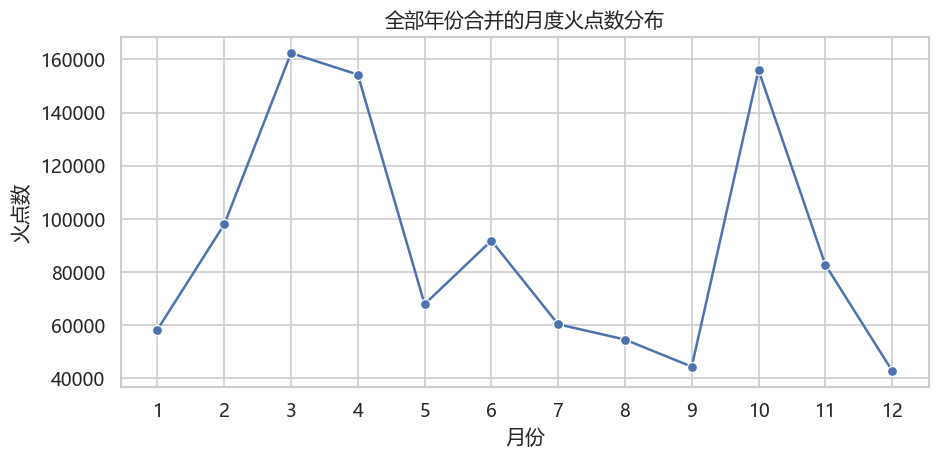

保存: f:\github desktop\course5020-project\results\all_years_monthly_fire_counts.csv


In [24]:
# 月度聚合与折线图
if len(fire_gdf) > 0:
    monthly = fire_gdf.groupby('month').size().rename('count').reset_index()
    monthly = monthly.sort_values('month')

    plt.figure(figsize=(8,4))
    sns.lineplot(data=monthly, x='month', y='count', marker='o')
    plt.title('全部年份合并的月度火点数分布')
    plt.xlabel('月份')
    plt.ylabel('火点数')
    plt.xticks(range(1,13))
    plt.tight_layout()
    plt.show()

    # 保存 CSV 与图
    monthly_out = RESULTS_DIR / 'all_years_monthly_fire_counts.csv'
    monthly.to_csv(monthly_out, index=False)
    print('保存:', monthly_out)
else:
    print('无数据，跳过月度聚合。')

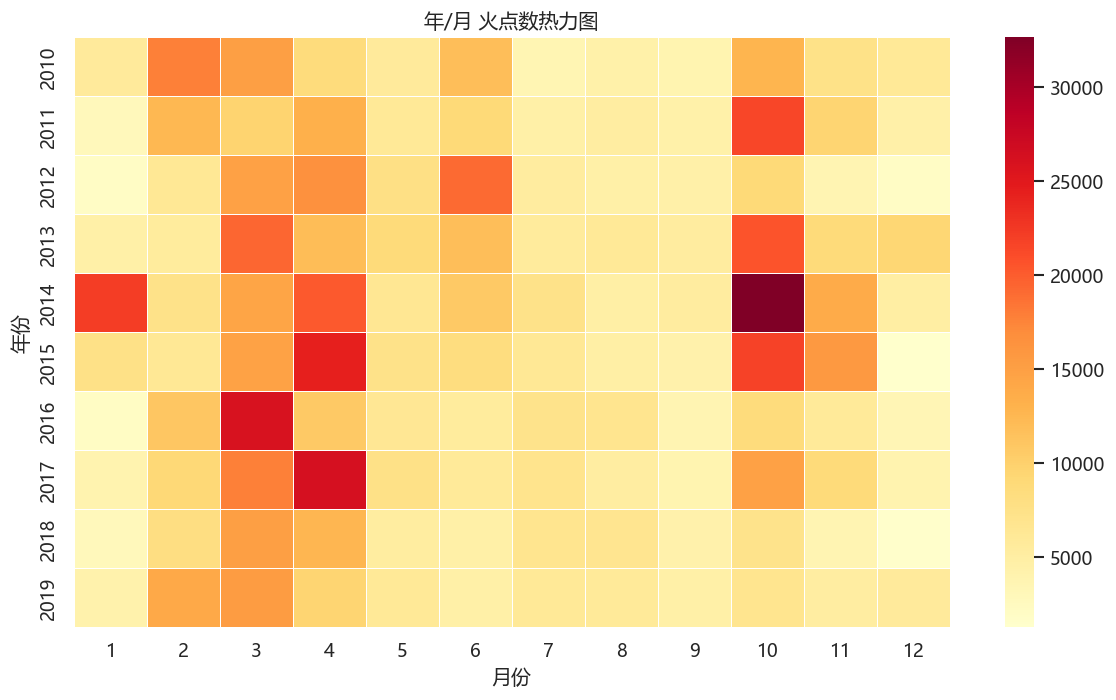

保存: f:\github desktop\course5020-project\results\year_month_fire_counts.csv


In [30]:
# 年 × 月 热力图（观察年内季节峰值与跨年差异）
if len(fire_gdf) > 0:
    year_month = fire_gdf.groupby(['year','month']).size().rename('count').reset_index()
    # 仅保留合理年份（从文件名或数据解析获得）
    if 'year_from_fname' in fire_gdf.columns:
        year_month = fire_gdf.groupby(['year_from_fname','month']).size().rename('count').reset_index()
        year_month = year_month.rename(columns={'year_from_fname':'year'})

    pivot = year_month.pivot(index='year', columns='month', values='count').fillna(0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.3, linecolor='white')
    plt.title('年/月 火点数热力图')
    plt.xlabel('月份')
    plt.ylabel('年份')
    plt.tight_layout()
    plt.show()

    # 导出
    ym_out = RESULTS_DIR / 'year_month_fire_counts.csv'
    pivot.to_csv(ym_out)
    print('保存:', ym_out)
else:
    print('无数据，跳过年/月热力图。')

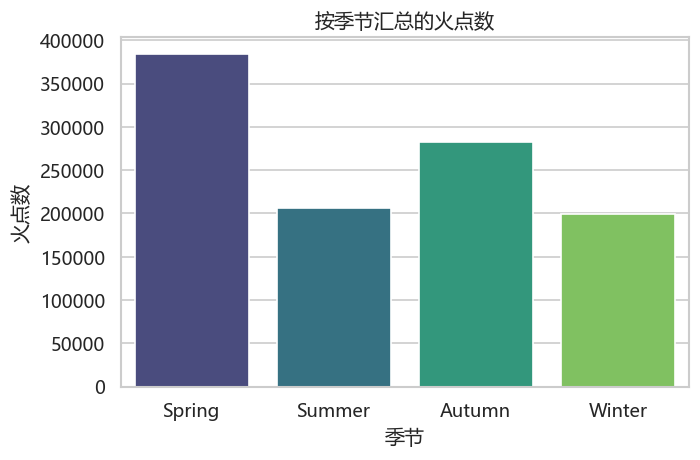

保存: f:\github desktop\course5020-project\results\season_fire_counts.csv


In [26]:
# 按季节汇总（春夏秋冬）
if len(fire_gdf) > 0:
    season_counts = fire_gdf.groupby('season').size().rename('count').reset_index()
    order = ['Spring','Summer','Autumn','Winter']
    season_counts['season'] = pd.Categorical(season_counts['season'], categories=order, ordered=True)
    season_counts = season_counts.sort_values('season')

    plt.figure(figsize=(6,4))
    sns.barplot(data=season_counts, x='season', y='count', palette='viridis')
    plt.title('按季节汇总的火点数')
    plt.xlabel('季节')
    plt.ylabel('火点数')
    plt.tight_layout()
    plt.show()

    season_out = RESULTS_DIR / 'season_fire_counts.csv'
    season_counts.to_csv(season_out, index=False)
    print('保存:', season_out)
else:
    print('无数据，跳过季节汇总。')

# 趋势分析与显著性检验：思路说明
本节使用非参数 Mann–Kendall 检验与 Sen’s slope 估计：
- 年度总量序列（2010–2019）检验整体趋势及显著性，并输出结果与趋势图。
- 按月份（1–12）构造“逐年同月火点数”序列，分别进行趋势检验，比较各月趋势差异。

保存: f:\github desktop\course5020-project\results\yearly_mk_trend_summary.csv


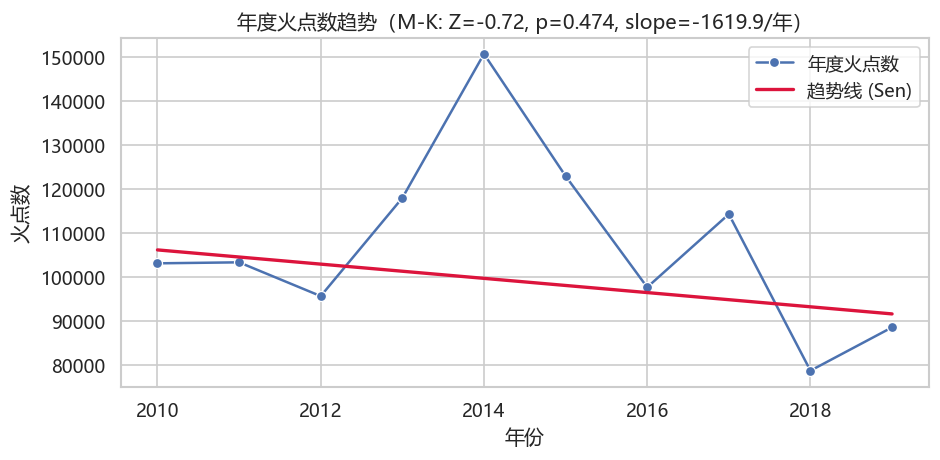

保存: f:\github desktop\course5020-project\results\yearly_trend.png


In [27]:
# 年度总量的 Mann–Kendall 趋势检验与 Sen 斜率
import math
from itertools import combinations

if len(fire_gdf) > 0:
    # 选择年份字段
    yr_col = 'year_from_fname' if 'year_from_fname' in fire_gdf.columns else 'year'
    yearly = fire_gdf.groupby(yr_col).size().rename('count').reset_index().sort_values(yr_col)
    years = yearly[yr_col].to_numpy()
    x = years.astype(float)
    y = yearly['count'].to_numpy(dtype=float)

    def mk_test(series):
        s = 0
        n = len(series)
        # S 统计量
        for i in range(n-1):
            diff = series[i+1:] - series[i]
            s += np.sign(diff).sum()
        # 方差（考虑 ties）
        unique, counts = np.unique(series, return_counts=True)
        tie_term = np.sum(counts*(counts-1)*(2*counts+5))
        var_s = (n*(n-1)*(2*n+5) - tie_term) / 18.0
        if s > 0:
            z = (s - 1)/math.sqrt(var_s)
        elif s < 0:
            z = (s + 1)/math.sqrt(var_s)
        else:
            z = 0.0
        # 正态分布双尾 p 值（使用 erf 近似）
        p = 2*(1 - 0.5*(1 + math.erf(abs(z)/math.sqrt(2))))
        return s, var_s, z, p

    def sen_slope(t, series):
        # t 为严格递增的时间（可用年份或索引）
        slopes = []
        n = len(series)
        for i in range(n-1):
            dy = series[i+1:] - series[i]
            dt = t[i+1:] - t[i]
            valid = dt != 0
            if np.any(valid):
                slopes.extend((dy[valid]/dt[valid]).tolist())
        if len(slopes) == 0:
            return 0.0
        return float(np.median(slopes))

    S, VAR_S, Z, P = mk_test(y)
    slope = sen_slope(x, y)
    # Theil–Sen 拦截：median(y - slope*x)
    intercept = float(np.median(y - slope*x))

    # 结果表
    from pandas import DataFrame
    res_df = DataFrame({
        'metric': ['S','VAR_S','Z','p_value','Sen_slope','intercept','n'],
        'value':  [S, VAR_S, Z, P, slope, intercept, len(y)]
    })
    out_csv = RESULTS_DIR / 'yearly_mk_trend_summary.csv'
    res_df.to_csv(out_csv, index=False)
    print('保存:', out_csv)

    # 绘图：年度总量 + 趋势线
    plt.figure(figsize=(8,4))
    sns.lineplot(x=years, y=y, marker='o', label='年度火点数')
    plt.plot(years, intercept + slope*x, color='crimson', linewidth=2, label='趋势线 (Sen)')
    title = f"年度火点数趋势（M-K: Z={Z:.2f}, p={P:.3f}, slope={slope:.1f}/年）"
    plt.title(title)
    plt.xlabel('年份')
    plt.ylabel('火点数')
    plt.legend()
    plt.tight_layout()
    out_png = RESULTS_DIR / 'yearly_trend.png'
    plt.savefig(out_png, dpi=150)
    plt.show()
    print('保存:', out_png)
else:
    print('无数据，跳过年度趋势检验。')

保存: f:\github desktop\course5020-project\results\monthly_mk_trend_summary.csv


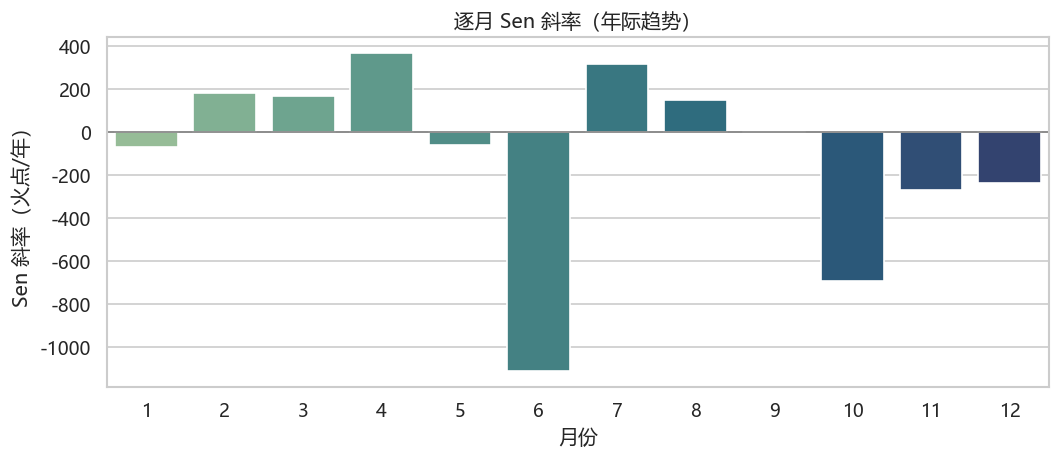

保存: f:\github desktop\course5020-project\results\monthly_sen_slopes.png


In [28]:
# 按月逐年序列的 Mann–Kendall 趋势检验
import math

if len(fire_gdf) > 0:
    yr_col = 'year_from_fname' if 'year_from_fname' in fire_gdf.columns else 'year'
    years_all = np.sort(fire_gdf[yr_col].dropna().unique())

    def mk_test(series):
        s = 0
        n = len(series)
        for i in range(n-1):
            diff = series[i+1:] - series[i]
            s += np.sign(diff).sum()
        unique, counts = np.unique(series, return_counts=True)
        tie_term = np.sum(counts*(counts-1)*(2*counts+5))
        var_s = (n*(n-1)*(2*n+5) - tie_term) / 18.0
        if s > 0:
            z = (s - 1)/math.sqrt(var_s)
        elif s < 0:
            z = (s + 1)/math.sqrt(var_s)
        else:
            z = 0.0
        p = 2*(1 - 0.5*(1 + math.erf(abs(z)/math.sqrt(2))))
        return s, var_s, z, p

    def sen_slope(t, series):
        slopes = []
        n = len(series)
        for i in range(n-1):
            dy = series[i+1:] - series[i]
            dt = t[i+1:] - t[i]
            valid = dt != 0
            if np.any(valid):
                slopes.extend((dy[valid]/dt[valid]).tolist())
        if len(slopes) == 0:
            return 0.0
        return float(np.median(slopes))

    rows = []
    for m in range(1, 13):
        sub = fire_gdf[fire_gdf['month'] == m]
        counts = sub.groupby(yr_col).size().reindex(years_all, fill_value=0)
        x = years_all.astype(float)
        y = counts.to_numpy(dtype=float)
        S, VAR_S, Z, P = mk_test(y)
        slope = sen_slope(x, y)
        rows.append({'month': m, 'S': S, 'VAR_S': VAR_S, 'Z': Z, 'p_value': P, 'Sen_slope': slope, 'n': len(y)})

    month_mk = pd.DataFrame(rows)
    out_csv = RESULTS_DIR / 'monthly_mk_trend_summary.csv'
    month_mk.to_csv(out_csv, index=False)
    print('保存:', out_csv)

    # 可视化：按月 Sen 斜率柱状图
    plt.figure(figsize=(9,4))
    sns.barplot(data=month_mk, x='month', y='Sen_slope', palette='crest')
    plt.axhline(0, color='gray', linewidth=1)
    plt.title('逐月 Sen 斜率（年际趋势）')
    plt.xlabel('月份')
    plt.ylabel('Sen 斜率（火点/年）')
    plt.tight_layout()
    out_png = RESULTS_DIR / 'monthly_sen_slopes.png'
    plt.savefig(out_png, dpi=150)
    plt.show()
    print('保存:', out_png)
else:
    print('无数据，跳过逐月趋势检验。')

# 地理分布：思路说明
本节从空间维度刻画火灾活动的主导模式：
- 将火点与县界做空间连接，得到县域尺度的火点统计（总量、分年）。
- 绘制县域层面的连续色斑图（choropleth），展示空间分布格局。
- 输出统计结果到 `results/` 供后续分析或图件制备。

保存: f:\github desktop\course5020-project\results\county_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_year_fire_counts.csv


<Figure size 960x960 with 0 Axes>

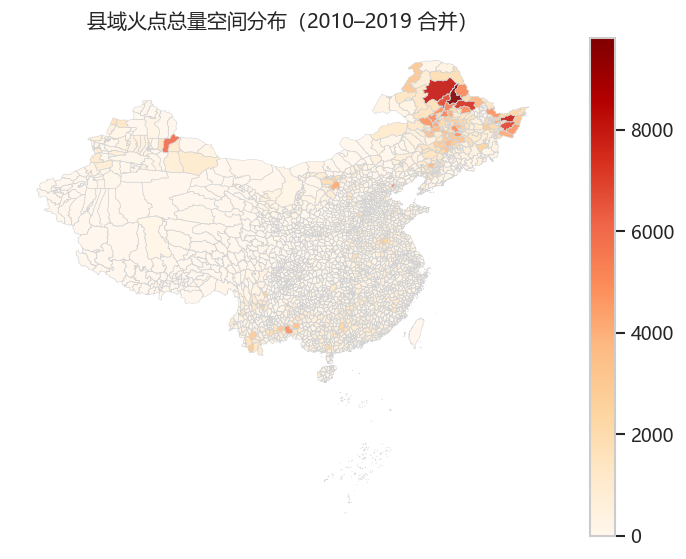

In [29]:
# 读取县界并进行空间连接
if len(fire_gdf) > 0 and COUNTY_SHP.exists():
    counties = gpd.read_file(COUNTY_SHP)
    # 标准化 CRS 为 WGS84（若非 WGS84，则投影到 EPSG:4326）
    try:
        if counties.crs is None:
            # 常见中国县 shapefile 多为经纬度坐标
            counties = counties.set_crs('EPSG:4326')
        elif counties.crs.to_epsg() != 4326:
            counties = counties.to_crs(4326)
    except Exception:
        counties = counties.to_crs(4326)

    # 空间连接（点在面内）
    join = gpd.sjoin(fire_gdf[['geometry','year']], counties, how='left', predicate='within')

    # 解决 sjoin 造成的同名列冲突（例如 counties 也有 year 字段，会生成 year_left / year_right）
    if 'year_left' in join.columns and 'year_right' in join.columns:
        # 优先使用点表（fire_gdf）的年份信息（year_left）
        join = join.rename(columns={'year_left': 'year'})
        # 去掉面表的 year_right（若需要可改名保留）
        join = join.drop(columns=['year_right'])
    elif 'year_left' in join.columns:
        join = join.rename(columns={'year_left': 'year'})
    elif 'year_right' in join.columns and 'year' not in join.columns:
        join = join.rename(columns={'year_right': 'year'})

    # 尝试找到县级唯一标识字段（若未知，则使用索引）
    candidate_keys = ['county_id','adcode','code','id','County_ID','COUNTY_ID']
    key = None
    for c in candidate_keys:
        if c in join.columns:
            key = c
            break
    if key is None:
        # 若没有明确字段，恢复到 counties 的索引作为标识
        counties = counties.reset_index().rename(columns={'index':'county_idx'})
        join = gpd.sjoin(fire_gdf[['geometry','year']], counties, how='left', predicate='within')
        # 再次处理重命名（同上）
        if 'year_left' in join.columns and 'year_right' in join.columns:
            join = join.rename(columns={'year_left': 'year'}).drop(columns=['year_right'])
        elif 'year_left' in join.columns:
            join = join.rename(columns={'year_left': 'year'})
        elif 'year_right' in join.columns and 'year' not in join.columns:
            join = join.rename(columns={'year_right': 'year'})
        key = 'county_idx'

    # 县域总量
    county_counts = join.groupby(key).size().rename('fire_count').reset_index()
    county_stats = counties.merge(county_counts, on=key, how='left')
    county_stats['fire_count'] = county_stats['fire_count'].fillna(0).astype(int)

    # 县域×年份（确保 join 中有 'year' 列）
    if 'year' not in join.columns:
        raise KeyError("'year' 列在空间连接结果中缺失，无法按年份统计。")
    county_year = join.groupby([key,'year']).size().rename('fire_count').reset_index()

    # 导出
    out_county_all = RESULTS_DIR / 'county_fire_counts.csv'
    out_county_year = RESULTS_DIR / 'county_year_fire_counts.csv'
    county_stats.drop(columns='geometry').to_csv(out_county_all, index=False)
    county_year.to_csv(out_county_year, index=False)
    print('保存:', out_county_all)
    print('保存:', out_county_year)

    # 绘制县域总量分布
    plt.figure(figsize=(8,8))
    ax = counties.boundary.plot(edgecolor='lightgray', linewidth=0.3)
    county_stats.plot(column='fire_count', ax=ax, legend=True, cmap='OrRd', linewidth=0, alpha=0.9)
    plt.title('县域火点总量空间分布（2010–2019 合并）')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    if not COUNTY_SHP.exists():
        print('未找到县界文件:', COUNTY_SHP)
    else:
        print('无火点数据，跳过空间连接。')

# 周尺度与季节内模式：思路说明
本节旨在超越“月度统计”，识别更细粒度的时间结构：
- 周尺度（ISO 周）：
  - 生成年×周热力图，观察热点周是否跨年一致；
  - 计算跨年每周的均值/中位数/分位数，找出“热点周”。
- 季节内（week-in-season）：
  - 将每季按周序列化，比较季节内部的固定峰周或变动周；
  - 识别各季的热点周并导出结果。

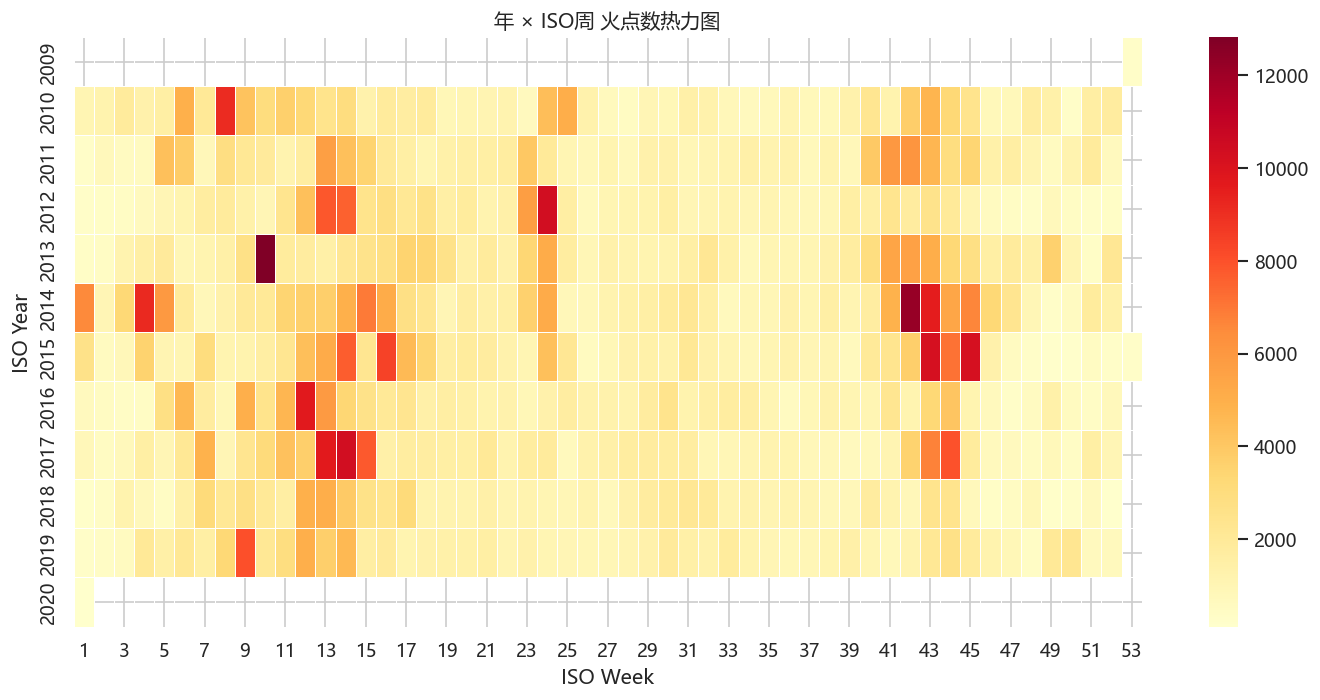

保存: f:\github desktop\course5020-project\results\year_week_fire_counts_heatmap.png
保存: f:\github desktop\course5020-project\results\year_week_fire_counts.csv
保存: f:\github desktop\course5020-project\results\week_of_year_stats.csv
保存: f:\github desktop\course5020-project\results\hot_weeks_summary.csv


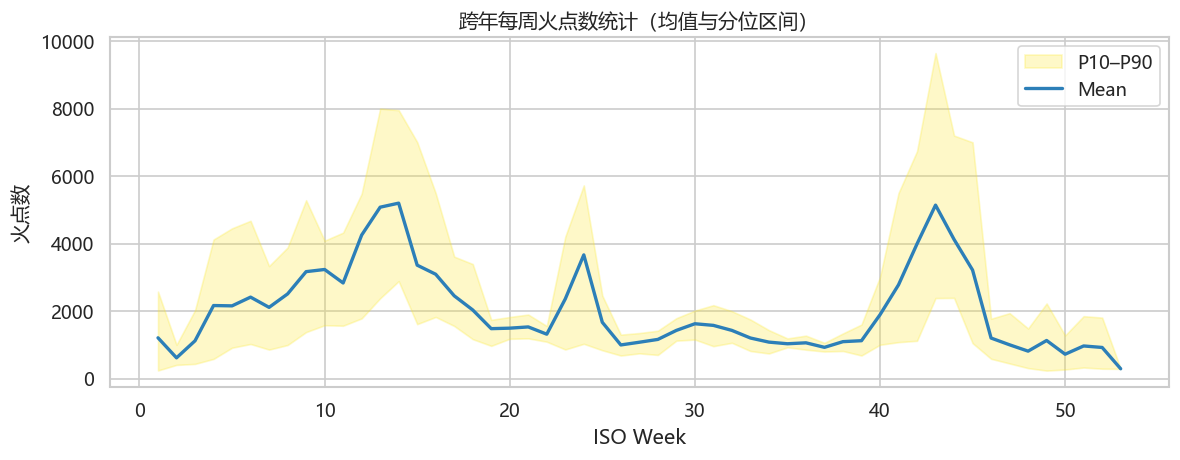

保存: f:\github desktop\course5020-project\results\week_of_year_curve.png


In [31]:
# 周尺度聚合与热点周识别（ISO Week）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if len(fire_gdf) > 0:
    # 计算 ISO 年/周（注意：返回的是 Int64 类型，需要转 int）
    iso = fire_gdf['datetime'].dt.isocalendar()
    fire_gdf['iso_year'] = iso['year'].astype(int)
    fire_gdf['iso_week'] = iso['week'].astype(int)

    weekly = fire_gdf.groupby(['iso_year','iso_week']).size().rename('count').reset_index()

    # 年×周热力图
    years = np.sort(weekly['iso_year'].unique())
    weeks = np.arange(1, 54)  # 1..53 周
    pivot = weekly.pivot(index='iso_year', columns='iso_week', values='count')
    pivot = pivot.reindex(index=years, columns=weeks, fill_value=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.3, linecolor='white')
    plt.title('年 × ISO周 火点数热力图')
    plt.xlabel('ISO Week')
    plt.ylabel('ISO Year')
    plt.tight_layout()
    heat_out = RESULTS_DIR / 'year_week_fire_counts_heatmap.png'
    plt.savefig(heat_out, dpi=150)
    plt.show()
    print('保存:', heat_out)

    # 导出年×周表
    yw_out = RESULTS_DIR / 'year_week_fire_counts.csv'
    pivot.to_csv(yw_out)
    print('保存:', yw_out)

    # 跨年每周统计（均值/中位数/分位）
    stats = pd.DataFrame({
        'week': weeks,
        'mean': pivot.mean(axis=0).values,
        'median': pivot.median(axis=0).values,
        'p10': pivot.quantile(0.10, axis=0).values,
        'p90': pivot.quantile(0.90, axis=0).values
    })
    stats_out = RESULTS_DIR / 'week_of_year_stats.csv'
    stats.to_csv(stats_out, index=False)
    print('保存:', stats_out)

    # 识别热点周（两种方式：Top-N 与阈值）
    top_n = 10
    top_weeks = stats.sort_values('mean', ascending=False).head(top_n).copy()
    # 阈值：均值 >= 均值均值 + 1 标准差
    mu, sigma = stats['mean'].mean(), stats['mean'].std(ddof=0)
    thr = mu + sigma
    high_weeks = stats[stats['mean'] >= thr].copy()
    hot = top_weeks.merge(high_weeks, on='week', how='outer', suffixes=('_top',''))
    hot = hot.sort_values('mean', ascending=False).reset_index(drop=True)
    hot_out = RESULTS_DIR / 'hot_weeks_summary.csv'
    hot.to_csv(hot_out, index=False)
    print('保存:', hot_out)

    # 可视化：每周均值曲线 + p10-p90 区间
    plt.figure(figsize=(10,4))
    plt.fill_between(stats['week'], stats['p10'], stats['p90'], color='#FDE725', alpha=0.25, label='P10–P90')
    plt.plot(stats['week'], stats['mean'], color='#2C7FB8', linewidth=2, label='Mean')
    plt.title('跨年每周火点数统计（均值与分位区间）')
    plt.xlabel('ISO Week')
    plt.ylabel('火点数')
    plt.legend()
    plt.tight_layout()
    wcurve_out = RESULTS_DIR / 'week_of_year_curve.png'
    plt.savefig(wcurve_out, dpi=150)
    plt.show()
    print('保存:', wcurve_out)
else:
    print('无数据，跳过周尺度分析。')

保存: f:\github desktop\course5020-project\results\season_week_stats.csv
保存: f:\github desktop\course5020-project\results\season_hotspot_weeks.csv


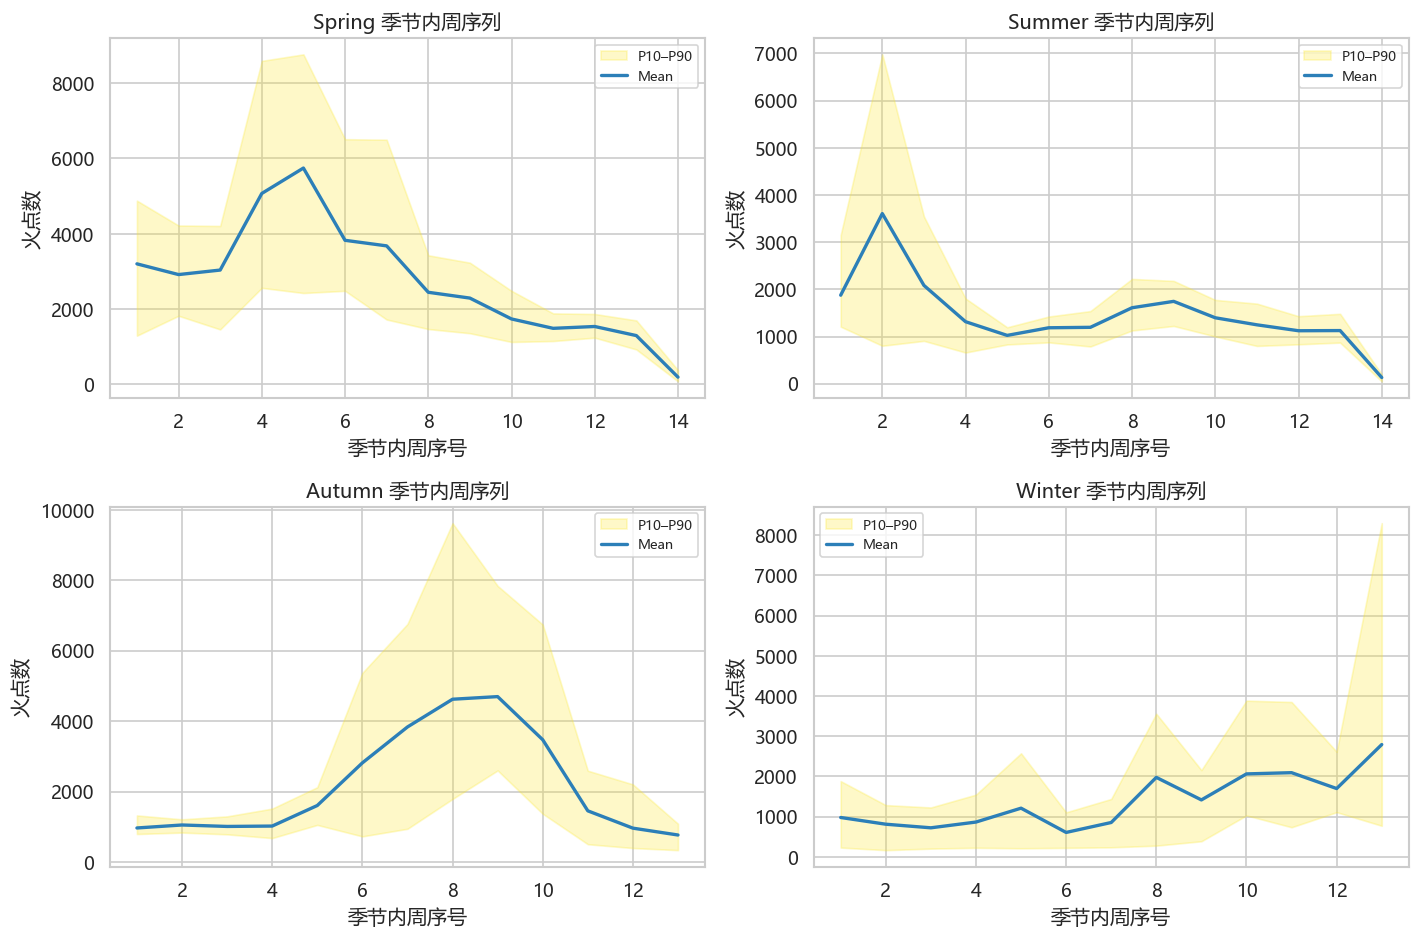

保存: f:\github desktop\course5020-project\results\season_week_curves.png


In [32]:
# 季节内（week-in-season）模式与热点周
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

if len(fire_gdf) > 0:
    # 计算 season_year：Winter 跨年，12月属于当年冬季，其余 1-2 月属于上一年冬季
    def compute_season_year(row):
        m = row['month']
        y = row['year']
        s = row['season']
        if s == 'Winter':
            if m == 12:
                return y
            else:  # 1,2 月
                return y - 1
        else:
            return y

    fire_gdf['season_year'] = fire_gdf.apply(compute_season_year, axis=1)

    # 计算季节起始日期
    season_start_month = {'Spring':3,'Summer':6,'Autumn':9,'Winter':12}
    def compute_season_start(row):
        sy = int(row['season_year'])
        mon = season_start_month.get(row['season'], 1)
        return datetime(sy, mon, 1)

    fire_gdf['season_start'] = fire_gdf.apply(compute_season_start, axis=1)

    # 计算季节内的周序号（从1开始）
    delta_days = (fire_gdf['datetime'] - fire_gdf['season_start']).dt.days
    fire_gdf['week_in_season'] = (delta_days // 7).astype(int) + 1

    # 聚合：按 season_year × season × week_in_season 统计
    ssw = fire_gdf.groupby(['season_year','season','week_in_season']).size().rename('count').reset_index()

    # 跨年统计：对每个 season 的同一 week_in_season 计算均值/分位
    def season_stats(season_name):
        sub = ssw[ssw['season'] == season_name]
        if sub.empty:
            return pd.DataFrame(columns=['season','week_in_season','mean','median','p10','p90'])
        weeks = np.sort(sub['week_in_season'].unique())
        # 构造 pivot: 行=season_year，列=week_in_season
        pivot = sub.pivot(index='season_year', columns='week_in_season', values='count').reindex(columns=weeks).fillna(0)
        return pd.DataFrame({
            'season': season_name,
            'week_in_season': weeks,
            'mean': pivot.mean(axis=0).values,
            'median': pivot.median(axis=0).values,
            'p10': pivot.quantile(0.10, axis=0).values,
            'p90': pivot.quantile(0.90, axis=0).values
        })

    seasons = ['Spring','Summer','Autumn','Winter']
    stats_list = [season_stats(s) for s in seasons]
    season_stats_df = pd.concat(stats_list, ignore_index=True) if stats_list else pd.DataFrame()

    # 导出季节内统计
    sstats_out = RESULTS_DIR / 'season_week_stats.csv'
    season_stats_df.to_csv(sstats_out, index=False)
    print('保存:', sstats_out)

    # 识别各季热点周（按均值 Top-3 + 阈值）
    hot_rows = []
    for s in seasons:
        sub = season_stats_df[season_stats_df['season'] == s]
        if sub.empty:
            continue
        top3 = sub.sort_values('mean', ascending=False).head(3).copy()
        mu, sigma = sub['mean'].mean(), sub['mean'].std(ddof=0)
        thr = mu + sigma
        over = sub[sub['mean'] >= thr].copy()
        top3['flag'] = 'top3'
        over['flag'] = '>=mean+1sd'
        hot_rows.append(pd.concat([top3, over]).drop_duplicates(subset=['week_in_season']))
    season_hot = pd.concat(hot_rows, ignore_index=True) if hot_rows else pd.DataFrame()
    shot_out = RESULTS_DIR / 'season_hotspot_weeks.csv'
    season_hot.to_csv(shot_out, index=False)
    print('保存:', shot_out)

    # 绘图：四季子图，均值线 + P10-P90 阴影
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
    axes = axes.ravel()
    for i, s in enumerate(seasons):
        ax = axes[i]
        sub = season_stats_df[season_stats_df['season'] == s]
        if sub.empty:
            ax.set_title(f'{s}（无数据）')
            ax.axis('off')
            continue
        ax.fill_between(sub['week_in_season'], sub['p10'], sub['p90'], color='#FDE725', alpha=0.25, label='P10–P90')
        ax.plot(sub['week_in_season'], sub['mean'], color='#2C7FB8', linewidth=2, label='Mean')
        ax.set_title(f'{s} 季节内周序列')
        ax.set_xlabel('季节内周序号')
        ax.set_ylabel('火点数')
        ax.legend(fontsize=8)
    plt.tight_layout()
    sw_plot = RESULTS_DIR / 'season_week_curves.png'
    plt.savefig(sw_plot, dpi=150)
    plt.show()
    print('保存:', sw_plot)
else:
    print('无数据，跳过季节内周模式分析。')

In [33]:
# 自动生成简短摘要（可选）
# 依据“热点周”与“季节内热点周”生成要点摘要，便于写作引用
try:
    lines = []
    # 周尺度热点
    hot_path = RESULTS_DIR / 'hot_weeks_summary.csv'
    if hot_path.exists():
        hot = pd.read_csv(hot_path)
        if not hot.empty:
            top_rows = hot.sort_values('mean', ascending=False).head(5)
            weeks_str = ', '.join(str(int(w)) for w in top_rows['week'].tolist())
            lines.append(f"历史上均值最高的热点周（Top-5）：{weeks_str}（单位：周序号）")
    # 季节内热点
    shot_path = RESULTS_DIR / 'season_hotspot_weeks.csv'
    if shot_path.exists():
        shot = pd.read_csv(shot_path)
        if not shot.empty:
            for s in ['Spring','Summer','Autumn','Winter']:
                sub = shot[shot['season']==s].sort_values('mean', ascending=False)
                top = sub.head(3)
                if not top.empty:
                    wks = ', '.join(str(int(w)) for w in top['week_in_season'].tolist())
                    lines.append(f"{s}热点周（Top-3）：{wks}")
    if lines:
        summary_path = RESULTS_DIR / 'summary_insights.txt'
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(lines))
        print('保存:', summary_path)
    else:
        print('暂无可写摘要（可能数据为空或前序单元未运行）。')
except Exception as e:
    print('生成摘要失败:', e)

保存: f:\github desktop\course5020-project\results\summary_insights.txt


# 热点周的空间分布：思路说明
为回答“热点周落在哪些区域更集中”，本节将：
- 读取已识别的热点周（基于跨年周均值 Top-N 与阈值筛选）。
- 以这些周的火点为子集，与县界做空间连接，统计“县域总量（热点周期间）”。
- 绘制：
  1) 聚合所有热点周的县域色斑图；
  2) 前 Top-K 热点周分别绘制县域色斑图，观察是否空间位置稳定。

选定热点周（Top-K）: [14, 43, 13]
保存: f:\github desktop\course5020-project\results\county_hot_weeks_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_hot_weeks_fire_counts.csv


<Figure size 960x960 with 0 Axes>

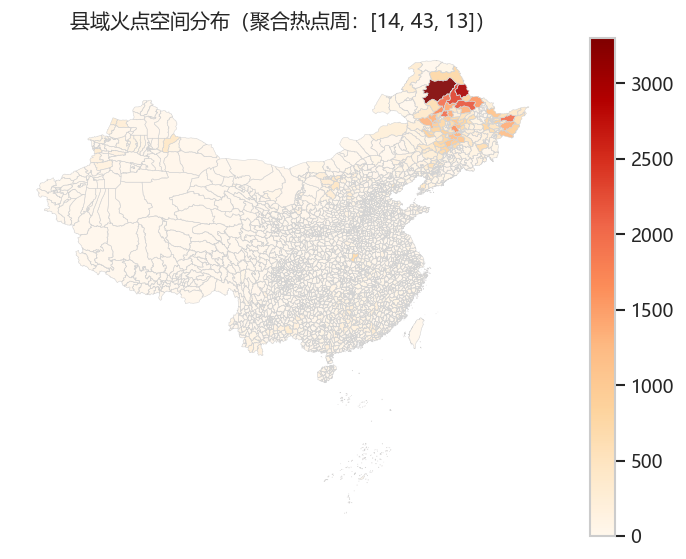

保存: f:\github desktop\course5020-project\results\county_hot_weeks_map.png
保存: f:\github desktop\course5020-project\results\county_hot_week_14_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_hot_week_14_fire_counts.csv


<Figure size 960x960 with 0 Axes>

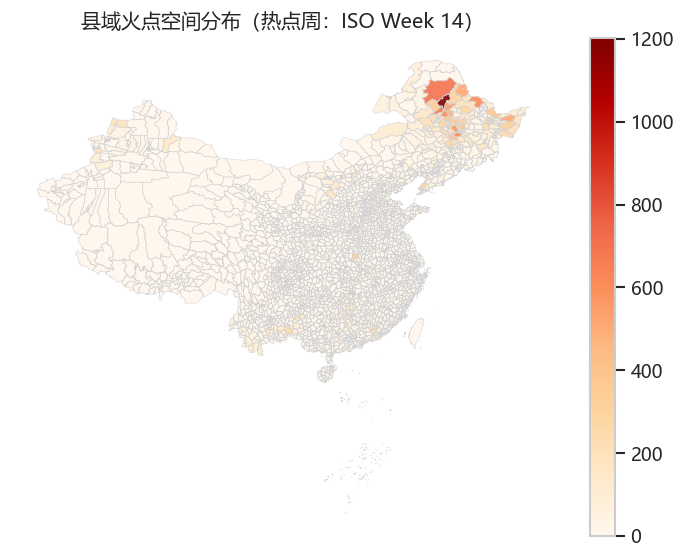

保存: f:\github desktop\course5020-project\results\county_hot_week_14_map.png
保存: f:\github desktop\course5020-project\results\county_hot_week_43_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_hot_week_43_fire_counts.csv


<Figure size 960x960 with 0 Axes>

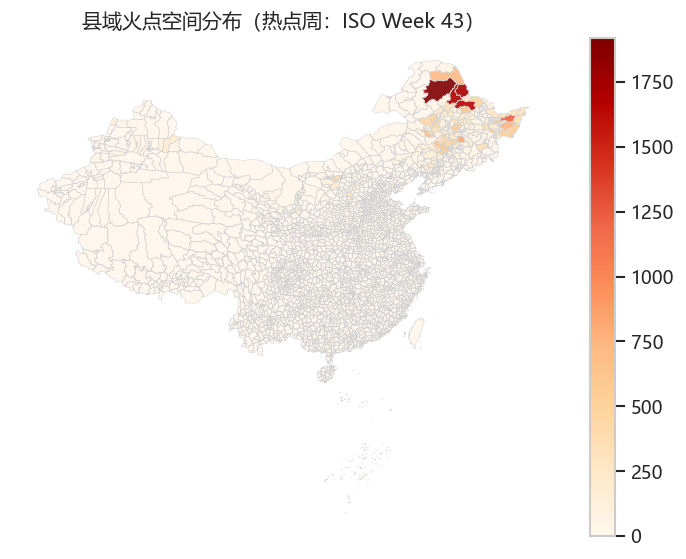

保存: f:\github desktop\course5020-project\results\county_hot_week_43_map.png
保存: f:\github desktop\course5020-project\results\county_hot_week_13_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_hot_week_13_fire_counts.csv


<Figure size 960x960 with 0 Axes>

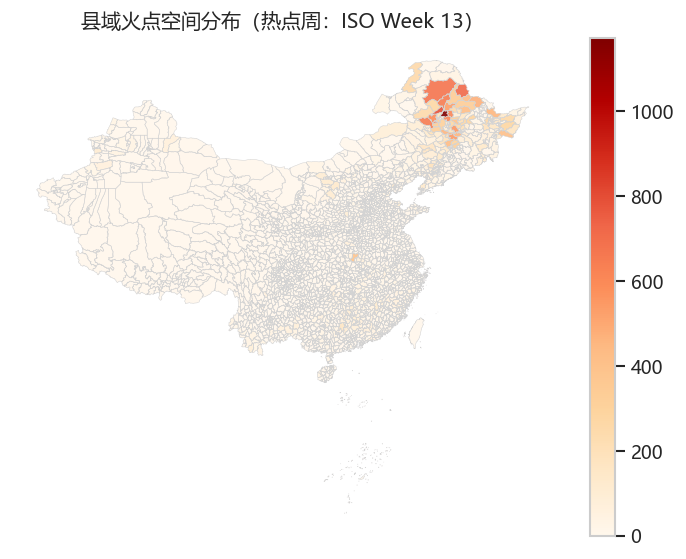

保存: f:\github desktop\course5020-project\results\county_hot_week_13_map.png


In [34]:
# 热点周（Top-K）的县域空间分布
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K_WEEKS = 3  # 可调：绘制前 K 个热点周

if len(fire_gdf) > 0 and COUNTY_SHP.exists():
    # 读热点周列表
    hot_path = RESULTS_DIR / 'hot_weeks_summary.csv'
    if not hot_path.exists():
        print('未找到热点周文件，尝试使用 week_of_year_stats.csv 的 Top 周替代。')
        stats_path = RESULTS_DIR / 'week_of_year_stats.csv'
        if stats_path.exists():
            stats = pd.read_csv(stats_path)
            hot_weeks = stats.sort_values('mean', ascending=False).head(TOP_K_WEEKS)['week'].astype(int).tolist()
        else:
            print('week_of_year_stats.csv 也不存在，无法进行热点周空间分析。')
            hot_weeks = []
    else:
        hot = pd.read_csv(hot_path)
        if 'week' not in hot.columns:
            print('hot_weeks_summary.csv 缺少 week 列，无法继续。')
            hot_weeks = []
        else:
            hot_weeks = hot.dropna(subset=['week']).sort_values('mean', ascending=False)['week'].astype(int).unique().tolist()
            hot_weeks = hot_weeks[:TOP_K_WEEKS]

    if len(hot_weeks) == 0:
        print('没有可用的热点周。')
    else:
        print('选定热点周（Top-K）:', hot_weeks)
        # 确保已计算 iso_week
        if 'iso_week' not in fire_gdf.columns:
            iso = fire_gdf['datetime'].dt.isocalendar()
            fire_gdf['iso_year'] = iso['year'].astype(int)
            fire_gdf['iso_week'] = iso['week'].astype(int)

        # 读取县界
        counties = gpd.read_file(COUNTY_SHP)
        try:
            if counties.crs is None:
                counties = counties.set_crs('EPSG:4326')
            elif counties.crs.to_epsg() != 4326:
                counties = counties.to_crs(4326)
        except Exception:
            counties = counties.to_crs(4326)

        # 寻找县级标识键
        candidate_keys = ['county_id','adcode','code','id','County_ID','COUNTY_ID']
        def detect_key(df_cols):
            for c in candidate_keys:
                if c in df_cols:
                    return c
            return None

        # 1) 聚合所有热点周的总量
        sub_all = fire_gdf[fire_gdf['iso_week'].isin(hot_weeks)][['geometry','year']].copy()
        join_all = gpd.sjoin(sub_all, counties, how='left', predicate='within')
        # 处理 year 列冲突
        if 'year_left' in join_all.columns and 'year_right' in join_all.columns:
            join_all = join_all.rename(columns={'year_left':'year'}).drop(columns=['year_right'])
        elif 'year_left' in join_all.columns:
            join_all = join_all.rename(columns={'year_left':'year'})
        elif 'year_right' in join_all.columns and 'year' not in join_all.columns:
            join_all = join_all.rename(columns={'year_right':'year'})

        key = detect_key(join_all.columns)
        if key is None:
            counties = counties.reset_index().rename(columns={'index':'county_idx'})
            join_all = gpd.sjoin(sub_all, counties, how='left', predicate='within')
            if 'year_left' in join_all.columns and 'year_right' in join_all.columns:
                join_all = join_all.rename(columns={'year_left':'year'}).drop(columns=['year_right'])
            elif 'year_left' in join_all.columns:
                join_all = join_all.rename(columns={'year_left':'year'})
            elif 'year_right' in join_all.columns and 'year' not in join_all.columns:
                join_all = join_all.rename(columns={'year_right':'year'})
            key = 'county_idx'

        county_counts_all = join_all.groupby(key).size().rename('fire_count').reset_index()
        county_stats_all = counties.merge(county_counts_all, on=key, how='left')
        county_stats_all['fire_count'] = county_stats_all['fire_count'].fillna(0).astype(int)

        out_csv_all = RESULTS_DIR / 'county_hot_weeks_fire_counts.csv'
        county_stats_all.drop(columns='geometry').to_csv(out_csv_all, index=False)
        print('保存:', out_csv_all)

        plt.figure(figsize=(8,8))
        ax = counties.boundary.plot(edgecolor='lightgray', linewidth=0.3)
        county_stats_all.plot(column='fire_count', ax=ax, legend=True, cmap='OrRd', linewidth=0, alpha=0.9)
        plt.title(f'县域火点空间分布（聚合热点周：{hot_weeks}）')
        plt.axis('off')
        plt.tight_layout()
        out_png_all = RESULTS_DIR / 'county_hot_weeks_map.png'
        plt.savefig(out_png_all, dpi=150)
        plt.show()
        print('保存:', out_png_all)

        # 2) 分别绘制前 TOP_K 周的地图
        for w in hot_weeks:
            sub_w = fire_gdf[fire_gdf['iso_week']==w][['geometry','year']].copy()
            join_w = gpd.sjoin(sub_w, counties, how='left', predicate='within')
            if 'year_left' in join_w.columns and 'year_right' in join_w.columns:
                join_w = join_w.rename(columns={'year_left':'year'}).drop(columns=['year_right'])
            elif 'year_left' in join_w.columns:
                join_w = join_w.rename(columns={'year_left':'year'})
            elif 'year_right' in join_w.columns and 'year' not in join_w.columns:
                join_w = join_w.rename(columns={'year_right':'year'})

            key_w = detect_key(join_w.columns)
            if key_w is None:
                key_w = key  # 回退到上面选择的键

            county_counts_w = join_w.groupby(key_w).size().rename('fire_count').reset_index()
            county_stats_w = counties.merge(county_counts_w, on=key_w, how='left')
            county_stats_w['fire_count'] = county_stats_w['fire_count'].fillna(0).astype(int)

            out_csv_w = RESULTS_DIR / f'county_hot_week_{int(w)}_fire_counts.csv'
            county_stats_w.drop(columns='geometry').to_csv(out_csv_w, index=False)
            print('保存:', out_csv_w)

            plt.figure(figsize=(8,8))
            ax = counties.boundary.plot(edgecolor='lightgray', linewidth=0.3)
            county_stats_w.plot(column='fire_count', ax=ax, legend=True, cmap='OrRd', linewidth=0, alpha=0.9)
            plt.title(f'县域火点空间分布（热点周：ISO Week {int(w)}）')
            plt.axis('off')
            plt.tight_layout()
            out_png_w = RESULTS_DIR / f'county_hot_week_{int(w)}_map.png'
            plt.savefig(out_png_w, dpi=150)
            plt.show()
            print('保存:', out_png_w)
else:
    if not COUNTY_SHP.exists():
        print('未找到县界文件:', COUNTY_SHP)
    else:
        print('无火点数据，跳过热点周空间分析。')

保存: f:\github desktop\course5020-project\results\county_season_Spring_fire_counts.csv


<Figure size 960x960 with 0 Axes>

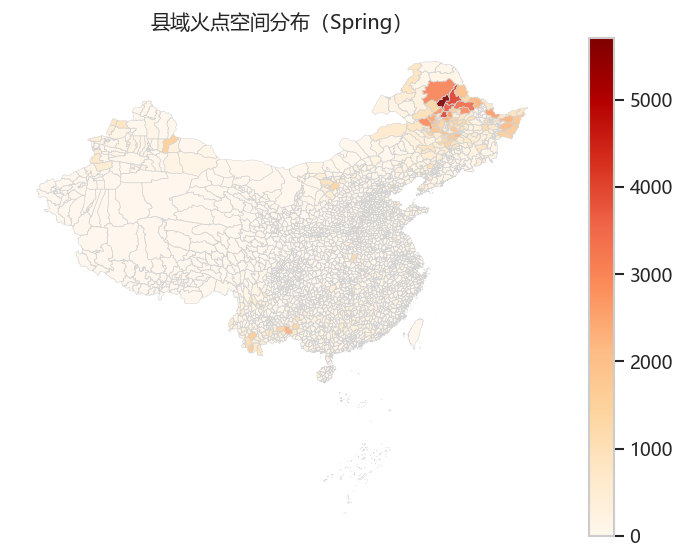

保存: f:\github desktop\course5020-project\results\county_season_Spring_map.png
保存: f:\github desktop\course5020-project\results\county_season_Summer_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_season_Summer_fire_counts.csv


<Figure size 960x960 with 0 Axes>

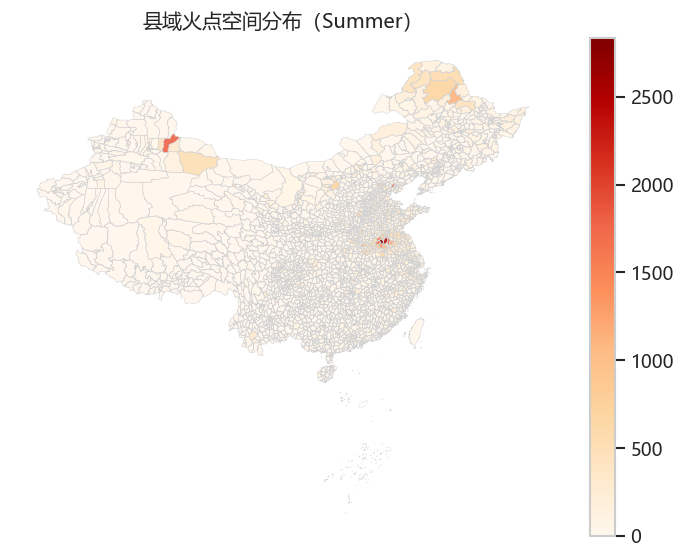

保存: f:\github desktop\course5020-project\results\county_season_Summer_map.png
保存: f:\github desktop\course5020-project\results\county_season_Autumn_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_season_Autumn_fire_counts.csv


<Figure size 960x960 with 0 Axes>

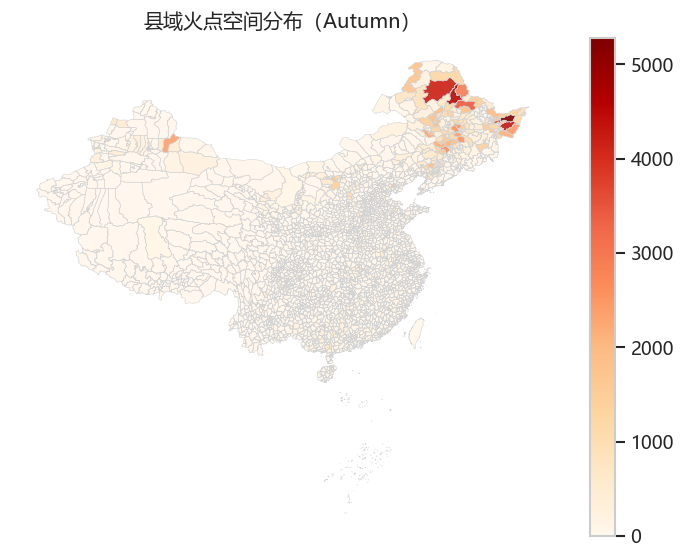

保存: f:\github desktop\course5020-project\results\county_season_Autumn_map.png
保存: f:\github desktop\course5020-project\results\county_season_Winter_fire_counts.csv
保存: f:\github desktop\course5020-project\results\county_season_Winter_fire_counts.csv


<Figure size 960x960 with 0 Axes>

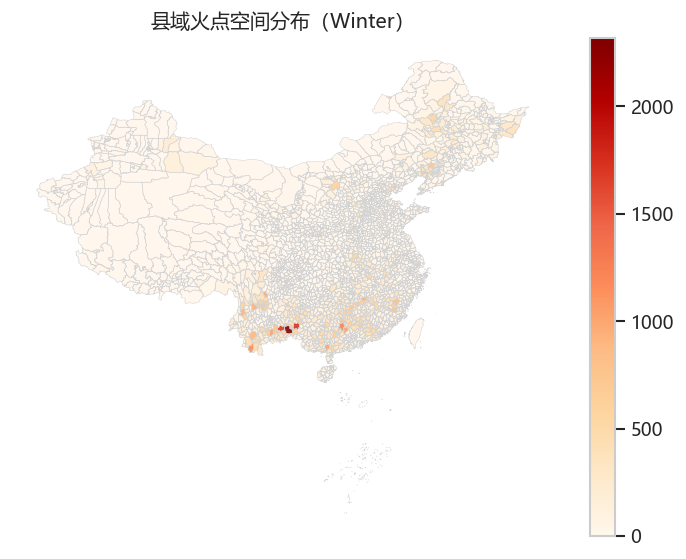

保存: f:\github desktop\course5020-project\results\county_season_Winter_map.png
保存: f:\github desktop\course5020-project\results\county_season_fire_counts.csv


In [35]:
# 季节分组的县域空间分布（可选增强）
# 将空间分布与季节性关联：按四季分别绘制县域色斑图，便于比较季节差异。
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

if len(fire_gdf) > 0 and COUNTY_SHP.exists():
    counties = gpd.read_file(COUNTY_SHP)
    try:
        if counties.crs is None:
            counties = counties.set_crs('EPSG:4326')
        elif counties.crs.to_epsg() != 4326:
            counties = counties.to_crs(4326)
    except Exception:
        counties = counties.to_crs(4326)

    seasons = ['Spring','Summer','Autumn','Winter']

    # 寻找县级标识键
    candidate_keys = ['county_id','adcode','code','id','County_ID','COUNTY_ID']
    def detect_key(df_cols):
        for c in candidate_keys:
            if c in df_cols:
                return c
        return None

    all_rows = []
    for s in seasons:
        sub = fire_gdf[fire_gdf['season']==s][['geometry','year']].copy()
        if sub.empty:
            continue
        join = gpd.sjoin(sub, counties, how='left', predicate='within')
        if 'year_left' in join.columns and 'year_right' in join.columns:
            join = join.rename(columns={'year_left':'year'}).drop(columns=['year_right'])
        elif 'year_left' in join.columns:
            join = join.rename(columns={'year_left':'year'})
        elif 'year_right' in join.columns and 'year' not in join.columns:
            join = join.rename(columns={'year_right':'year'})

        key = detect_key(join.columns)
        if key is None:
            counties = counties.reset_index().rename(columns={'index':'county_idx'})
            join = gpd.sjoin(sub, counties, how='left', predicate='within')
            if 'year_left' in join.columns and 'year_right' in join.columns:
                join = join.rename(columns={'year_left':'year'}).drop(columns=['year_right'])
            elif 'year_left' in join.columns:
                join = join.rename(columns={'year_left':'year'})
            elif 'year_right' in join.columns and 'year' not in join.columns:
                join = join.rename(columns={'year_right':'year'})
            key = 'county_idx'

        # 县域总量（该季汇总）
        counts = join.groupby(key).size().rename('fire_count').reset_index()
        counts['season'] = s
        all_rows.append(counts)

        stats_s = counties.merge(counts, on=key, how='left')
        stats_s['fire_count'] = stats_s['fire_count'].fillna(0).astype(int)

        out_csv_s = RESULTS_DIR / f'county_season_{s}_fire_counts.csv'
        stats_s.drop(columns='geometry').to_csv(out_csv_s, index=False)
        print('保存:', out_csv_s)

        plt.figure(figsize=(8,8))
        ax = counties.boundary.plot(edgecolor='lightgray', linewidth=0.3)
        stats_s.plot(column='fire_count', ax=ax, legend=True, cmap='OrRd', linewidth=0, alpha=0.9)
        plt.title(f'县域火点空间分布（{s}）')
        plt.axis('off')
        plt.tight_layout()
        out_png_s = RESULTS_DIR / f'county_season_{s}_map.png'
        plt.savefig(out_png_s, dpi=150)
        plt.show()
        print('保存:', out_png_s)

    if all_rows:
        all_df = pd.concat(all_rows, ignore_index=True)
        out_all = RESULTS_DIR / 'county_season_fire_counts.csv'
        all_df.to_csv(out_all, index=False)
        print('保存:', out_all)
else:
    if not COUNTY_SHP.exists():
        print('未找到县界文件:', COUNTY_SHP)
    else:
        print('无火点数据，跳过季节空间分析。')